In [1]:
%conda install -y -q opencv colorcet

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from bokeh.io import output_notebook, show
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import BasicTicker, ColorBar, LinearColorMapper, PointDrawTool, PrintfTickFormatter
from bokeh.transform import transform
from bokeh.events import Tap
import colorcet as cc

from floorplan import FloorPlan

#Bokeh config
output_notebook()
tools = "hover, box_zoom, undo, crosshair, wheel_zoom, pan, zoom_in, zoom_out, save"

Loading BokehJS ...

In [4]:
#IMAGE_FILE = 'ROBIN/Dataset_3rooms/Cat17_10.jpg'
IMAGE_FILE = 'sample_optimize.jpg'
#IMAGE_FILE = '/content/drive/MyDrive/Colab Notebooks/wifi-heatmap/mock.png'
floorplan = FloorPlan(IMAGE_FILE, scale = 30)

In [5]:
# Constants
SCALE = 1 # Value in meter for each pixel

TX_POWER = 0 #dBm
REFERENCE_LOSS_1M = 10 #dBm
PATH_LOSS_EXP = 2

#WALL_LOSS_THIN = 3.4 #dB
WALL_LOSS_THIN = 10 #dB
WALL_LOSS_THICK = 6.9 #dB

#Plot constants
ALPHA=1.0

In [6]:
# Calculate distance between coordinates using pythagoras theorem
def distance2d(src_x, src_y, dst_x, dst_y):
    dx = (dst_x-src_x)*SCALE
    dy = (dst_y-src_y)*SCALE
    return np.sqrt((dx**2)+(dy**2))

In [7]:
def plotWalls(df, p=None, show_plot=False):
    #Plot the walls
    if p == None:
        p = figure(title='Wallmap', 
            tools=tools, 
            #x_range=(df['x'].min(), df['x'].max()), 
            #y_range=(df['y'].min(), df['y'].max()),
            match_aspect=True,
            sizing_mode='scale_both'               
            )
    
    p.rect(
        x="x",
        y="y",
        width=1,
        height=1,
        source=ColumnDataSource(df.loc[(df['walls'] == 1)]),
        line_color=None,
        fill_color='black'
    )

    if show_plot:
        show(p)

In [8]:
def heatmap2d(df, column, palette='Inferno256', title='HeatMap', color_bar=True, plot_origin=True, origin=(0,0), handle=False):
    TOOLTIPS = [
    ("(x,y)", "(@x, @y)"),
    (f"{column}", f"@{column}"),
    ]
    
    p = figure(title=title, 
               tools=tools, 
               tooltips=TOOLTIPS,
               #x_range=(df['x'].min(), df['x'].max()), 
               #y_range=(df['y'].min(), df['y'].max()),
               match_aspect=True,
               sizing_mode='scale_both'               
              )
    
    mapper = LinearColorMapper(palette=palette, low=df[column].min(), high=df[column].max())
    
    #Plot the data
    p.rect(
        x="x",
        y="y",
        width=1,
        height=1,
        source=ColumnDataSource(df[['x','y',column]]),
        line_color=None,
        fill_color=transform(column, mapper),
        alpha=ALPHA,
        dilate=(True if ALPHA == 1.0 else False)
    )

    plotWalls(df, p=p, show_plot=False)

    p.axis.axis_line_color = None
    p.axis.major_tick_line_color = None
    p.axis.major_label_text_font_size = "5pt"
    p.axis.major_label_standoff = 0
    p.xaxis.major_label_orientation = 1.0

    if color_bar:
        # Add Legend Colorbar
        color_bar = ColorBar(
            color_mapper=mapper,
            location=(0, 0),
            ticker=BasicTicker(desired_num_ticks=int(len(mapper.palette)/5))
        )
        p.add_layout(color_bar, 'left')
    
    if plot_origin:
        #Plot a black square indicating the AP position
        p.rect(x=[origin[0]], y=[origin[1]], width=1, height=1, color='black')
 
    show(p)
    
    if handle:
        return p

In [9]:
def normalize_2d(matrix):
    return (matrix - np.min(matrix)) / (np.max(matrix) - np.min(matrix))

In [10]:
def path_loss_one_slope(src_x, src_y, dst_x, dst_y, ref_loss=REFERENCE_LOSS_1M, exponent=PATH_LOSS_EXP):
    dist = distance2d(src_x,src_y,dst_x,dst_y)
    return (ref_loss + 10*exponent*np.log10(dist)) if dist > 1 else ref_loss

In [11]:
def path_loss_multiwall(src_x, src_y, dst_x, dst_y, wall_count, ref_loss=REFERENCE_LOSS_1M, exponent=PATH_LOSS_EXP, wall_loss=WALL_LOSS_THIN, freq=2.4e9):
    dist = distance2d(src_x,src_y,dst_x,dst_y)
    if dist == 0:
        return ref_loss
    #FSPL = 10*np.log10(((4*np.pi*dist*freq)/299792458)**2)
    total_loss = ref_loss + 10*exponent*np.log10(dist) + wall_count*wall_loss
    return total_loss

In [12]:
def calc_loss(model, *argv):
    if model == 'ONE_SLOPE':
        return path_loss_one_slope(*argv)
    elif model == 'MULTIWALL':
        return path_loss_multiwall(*argv)

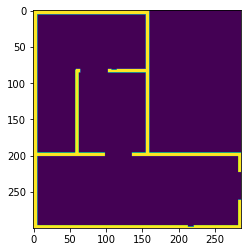

In [13]:
map = floorplan.getWallMap(morph=True, kernel=(4,4))
plt.imshow(map)

In [14]:
%%time
#Build lists for dataframe (this is way faster than appending data row-by-row on the dataframe)
data = []
for origin_x, origin_y, _,_,_,_ in floorplan.accessPoints:
    x_list = []
    y_list = []
    dist_list = []
    loss_list = []
    rssi_list = []
    wall_list = []

    for x in range(floorplan.x_size):
        for y in range(floorplan.y_size):
            #loss = calc_loss('ONE_SLOPE', ORIGIN_X, ORIGIN_Y, x, y)
            loss = calc_loss('MULTIWALL', origin_x, origin_y, x, y, floorplan.countWalls(origin_x, origin_y, x, y))
            #loss = path_loss_one_slope(ORIGIN_X, ORIGIN_Y, x, y)
            rssi = TX_POWER - loss
            dist_list.append(distance2d(origin_x, origin_y, x, y))
            loss_list.append(loss)
            rssi_list.append(rssi)
            x_list.append(x)
            y_list.append(y)
            wall_list.append(map[y][x])

    #Build dataframe at once
    df = pd.DataFrame({'x':x_list,'y':y_list,'dist':dist_list,'loss':loss_list,'rssi':rssi_list,'walls':wall_list})
    data.append(df)

CPU times: user 13.3 s, sys: 0 ns, total: 13.3 s
Wall time: 13.3 s


In [16]:
handlers = []
for df in data:
    h = heatmap2d(df, 'loss', title=f'RSSI Heatmap for AP on coordinates ({origin_x},{origin_y})', origin=(origin_x,origin_y), color_bar=True, handle=True)
    handlers.append(h)